In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import optuna
import joblib
from sklearn.metrics import make_scorer

In [45]:
df = pd.read_csv("Dados/AmesHousing.csv")

df

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,2926,923275080,80,RL,37.0,7937,Pave,NaN,IR1,Lvl,...,0,NaN,GdPrv,NaN,0,3,2006,WD,Normal,142500
2926,2927,923276100,20,RL,NaN,8885,Pave,NaN,IR1,Low,...,0,NaN,MnPrv,NaN,0,6,2006,WD,Normal,131000
2927,2928,923400125,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal,132000
2928,2929,924100070,20,RL,77.0,10010,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2006,WD,Normal,170000


Feature engeniering básica

In [46]:
df["HouseAge"] = df["Yr Sold"] - df["Year Built"]
df["RemodAge"] = df["Yr Sold"] - df["Year Remod/Add"]

In [47]:
TARGET = "SalePrice"

In [48]:
corr_houseage = df["HouseAge"].corr(df["SalePrice"])
corr_remodage = df["RemodAge"].corr(df["SalePrice"])

print(f"Correlação HouseAge x SalePrice: {corr_houseage:.3f}")
print(f"Correlação RemodAge x SalePrice: {corr_remodage:.3f}")

Correlação HouseAge x SalePrice: -0.559
Correlação RemodAge x SalePrice: -0.535


In [49]:
y = df[TARGET]
X = df.drop(columns=[TARGET])
print("Tamanho do dataset:", df.shape)
print("\nTipos de variáveis:\n", X.dtypes.value_counts())
#print("\nEstatísticas das variáveis numéricas:\n", X.describe().T)

Tamanho do dataset: (2930, 84)

Tipos de variáveis:
 object     43
int64      29
float64    11
Name: count, dtype: int64


In [50]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

In [51]:
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
print("Numéricas:", len(num_cols), "Categoricas:", len(cat_cols))

Numéricas: 40 Categoricas: 43


Pré-processamento: pipelines

In [43]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', num_pipeline, num_cols),
    ('cat', cat_pipeline, cat_cols)
], remainder='drop')

Função para avaliação


In [52]:
def evaluate_model(model, name):
    pipe = Pipeline([
        ('preproc', preprocessor),
        ('model', model)
    ])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    rmse = mean_squared_error(y_test, preds)
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    print(f"{name} -> RMSE: {rmse:.3f} | MAE: {mae:.3f} | R²: {r2:.3f}")
    return {'Modelo': name, 'RMSE': rmse, 'MAE': mae, 'R2': r2, 'pipeline': pipe}

In [53]:
X_transformed = preprocessor.fit_transform(X)

# Número final de atributos
X_transformed.shape

(2930, 323)

In [54]:
results = []
results.append(evaluate_model(LinearRegression(), "Linear Regression"))
results.append(evaluate_model(Ridge(random_state=42), "Ridge"))
results.append(evaluate_model(Lasso(random_state=42, max_iter=10000), "Lasso"))
results.append(evaluate_model(RandomForestRegressor(random_state=42, n_jobs=-1), "Random Forest"))
results.append(evaluate_model(xgb.XGBRegressor(random_state=42, n_jobs=-1, verbosity=0), "XGBoost"))

baseline_df = pd.DataFrame(results)[['Modelo', 'RMSE', 'MAE', 'R2']]
print("\nDesempenho inicial:\n", baseline_df.sort_values('RMSE'))

Linear Regression -> RMSE: 848804803.987 | MAE: 15711.885 | R²: 0.894
Ridge -> RMSE: 827240544.906 | MAE: 16160.765 | R²: 0.897


/home/chico/Projetos/P5/PE/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.073e+09, tolerance: 1.394e+09
  model = cd_fast.sparse_enet_coordinate_descent(


Lasso -> RMSE: 841459507.971 | MAE: 15674.243 | R²: 0.895
Random Forest -> RMSE: 684922268.037 | MAE: 15805.016 | R²: 0.915
XGBoost -> RMSE: 611864128.000 | MAE: 15178.443 | R²: 0.924

Desempenho inicial:
               Modelo          RMSE           MAE        R2
4            XGBoost  6.118641e+08  15178.443359  0.923684
3      Random Forest  6.849223e+08  15805.016433  0.914572
1              Ridge  8.272405e+08  16160.764847  0.896821
2              Lasso  8.414595e+08  15674.243362  0.895048
0  Linear Regression  8.488048e+08  15711.884949  0.894132


Tuning com OPTUNA – Random Forest e XGBoost

RandomForestRegressor

In [55]:
def objective_rf(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 600),
        'max_depth': trial.suggest_int('max_depth', 3, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 6)
    }
    model = RandomForestRegressor(random_state=42, n_jobs=-1, **params)
    pipe = Pipeline([('preproc', preprocessor), ('model', model)])
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(pipe, X_train, y_train,
                             cv=cv,
                             scoring=make_scorer(mean_squared_error))
    return scores.mean()

In [56]:
study_rf = optuna.create_study(direction='minimize', study_name='rf_tuning')
study_rf.optimize(objective_rf, n_trials=40)
print("Melhores parâmetros RF:", study_rf.best_params)

[I 2025-11-06 19:17:52,167] A new study created in memory with name: rf_tuning
[I 2025-11-06 19:18:09,864] Trial 0 finished with value: 751016800.6232698 and parameters: {'n_estimators': 295, 'max_depth': 11, 'min_samples_split': 5, 'min_samples_leaf': 2}. Best is trial 0 with value: 751016800.6232698.
[I 2025-11-06 19:18:19,009] Trial 1 finished with value: 819213758.3754938 and parameters: {'n_estimators': 327, 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 0 with value: 751016800.6232698.
[I 2025-11-06 19:18:50,680] Trial 2 finished with value: 742179636.7797563 and parameters: {'n_estimators': 511, 'max_depth': 21, 'min_samples_split': 6, 'min_samples_leaf': 3}. Best is trial 2 with value: 742179636.7797563.
[I 2025-11-06 19:19:08,078] Trial 3 finished with value: 746829097.105711 and parameters: {'n_estimators': 268, 'max_depth': 21, 'min_samples_split': 3, 'min_samples_leaf': 3}. Best is trial 2 with value: 742179636.7797563.
[I 2025-11-06 19:19:34,

Melhores parâmetros RF: {'n_estimators': 101, 'max_depth': 30, 'min_samples_split': 9, 'min_samples_leaf': 1}


In [57]:
best_rf = Pipeline([
    ('preproc', preprocessor),
    ('model', RandomForestRegressor(random_state=42, n_jobs=-1, **study_rf.best_params))
])
best_rf.fit(X_train, y_train)
rf_preds = best_rf.predict(X_test)
rf_rmse = mean_squared_error(y_test, rf_preds)
rf_mae = mean_absolute_error(y_test, rf_preds)
rf_r2 = r2_score(y_test, rf_preds)

XGBoost 

In [59]:
def objective_xgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 200, 800),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 10.0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 10.0, log=True)
    }
    model = xgb.XGBRegressor(random_state=42, n_jobs=-1, verbosity=0, **params)
    pipe = Pipeline([('preproc', preprocessor), ('model', model)])
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(pipe, X_train, y_train,
                             cv=cv,
                             scoring=make_scorer(mean_squared_error))
    return scores.mean()

In [60]:
study_xgb = optuna.create_study(direction='minimize', study_name='xgb_tuning')
study_xgb.optimize(objective_xgb, n_trials=40)
print("Melhores parâmetros XGB:", study_xgb.best_params)

[I 2025-11-06 19:28:19,411] A new study created in memory with name: xgb_tuning
[I 2025-11-06 19:29:54,411] Trial 0 finished with value: 658289817.6 and parameters: {'n_estimators': 775, 'max_depth': 13, 'learning_rate': 0.012833605684119667, 'subsample': 0.7930535163717367, 'colsample_bytree': 0.8933610939399047, 'min_child_weight': 5, 'gamma': 3.1874575477546054, 'reg_lambda': 0.02395422810965624, 'reg_alpha': 0.7855919343512261}. Best is trial 0 with value: 658289817.6.
[I 2025-11-06 19:30:04,556] Trial 1 finished with value: 690508556.8 and parameters: {'n_estimators': 329, 'max_depth': 10, 'learning_rate': 0.15797852418937763, 'subsample': 0.5391836946446917, 'colsample_bytree': 0.6664690741436469, 'min_child_weight': 9, 'gamma': 1.6329503753373475, 'reg_lambda': 0.07282166303126927, 'reg_alpha': 4.2640756825199855}. Best is trial 0 with value: 658289817.6.
[I 2025-11-06 19:30:37,623] Trial 2 finished with value: 658217356.8 and parameters: {'n_estimators': 790, 'max_depth': 9, 'l

Melhores parâmetros XGB: {'n_estimators': 644, 'max_depth': 8, 'learning_rate': 0.013831337624731347, 'subsample': 0.5574788331057567, 'colsample_bytree': 0.6203510863457031, 'min_child_weight': 9, 'gamma': 1.4236336331379926, 'reg_lambda': 0.10426482084538861, 'reg_alpha': 4.811831259716913}


In [61]:
best_xgb = Pipeline([
    ('preproc', preprocessor),
    ('model', xgb.XGBRegressor(random_state=42, n_jobs=-1, verbosity=0, **study_xgb.best_params))
])
best_xgb.fit(X_train, y_train)
xgb_preds = best_xgb.predict(X_test)
xgb_rmse = mean_squared_error(y_test, xgb_preds)
xgb_mae = mean_absolute_error(y_test, xgb_preds)
xgb_r2 = r2_score(y_test, xgb_preds)

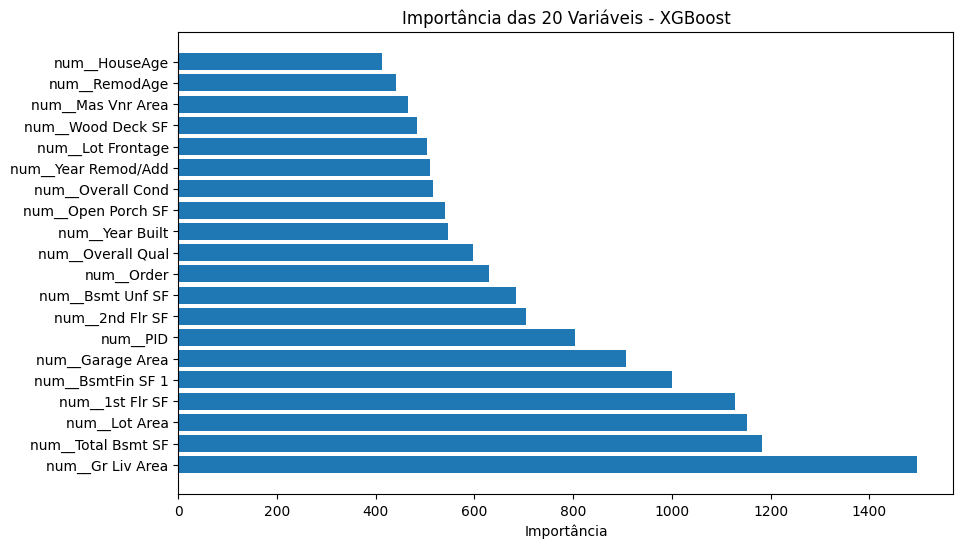

In [92]:
model_xgb = best_xgb.named_steps['model']
feature_names = best_xgb.named_steps['preproc'].get_feature_names_out()
importance = model_xgb.get_booster().get_score(importance_type='weight')

# Ordenar por importância (decrescente)
importance_sorted = sorted(importance.items(), key=lambda x: x[1], reverse=True)

top_n = 20
top_importance = importance_sorted[:top_n]

# Extraindo os nomes reais das variáveis
top_feature_names = [feature_names[int(item[0][1:])] for item in top_importance] 

plt.figure(figsize=(10, 6))
plt.barh(top_feature_names, [item[1] for item in top_importance])
plt.xlabel('Importância')
plt.title(f'Importância das {top_n} Variáveis - XGBoost')
plt.show()

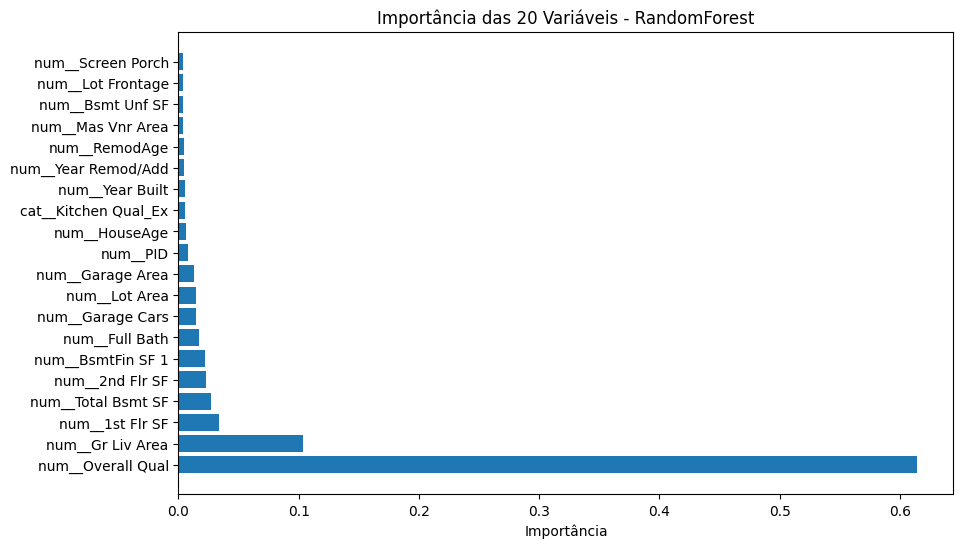

In [91]:
model_rf = best_rf.named_steps['model']
importances = model_rf.feature_importances_
preprocessor = best_rf.named_steps['preproc']
feature_names = preprocessor.get_feature_names_out(input_features=X_train.columns)

# Ordenar as variáveis por importância (decrescente)
indices = np.argsort(importances)[::-1]

# Selecionar as top 20 variáveis
top_n = 20
top_indices = indices[:top_n]
top_importance = importances[top_indices]
top_feature_names = feature_names[top_indices]

plt.figure(figsize=(10, 6))
plt.barh(top_feature_names, top_importance)
plt.xlabel('Importância')
plt.title(f'Importância das {top_n} Variáveis - RandomForest')
plt.show()

Resultados finais comparativos

In [94]:
final_df = pd.concat([
    baseline_df,
    pd.DataFrame([
        {'Modelo': 'RandomForest (Optuna)', 'RMSE': rf_rmse, 'MAE': rf_mae, 'R2': rf_r2},
        {'Modelo': 'XGBoost (Optuna)', 'RMSE': xgb_rmse, 'MAE': xgb_mae, 'R2': xgb_r2}
    ])
], ignore_index=True).sort_values('RMSE')
print("\nResultados finais comparativos:\n", final_df)


Resultados finais comparativos:
                   Modelo          RMSE           MAE        R2
6       XGBoost (Optuna)  6.101277e+08  13860.428711  0.923901
4                XGBoost  6.118641e+08  15178.443359  0.923684
3          Random Forest  6.849223e+08  15805.016433  0.914572
5  RandomForest (Optuna)  7.122133e+08  15889.139176  0.911168
1                  Ridge  8.272405e+08  16160.764847  0.896821
2                  Lasso  8.414595e+08  15674.243362  0.895048
0      Linear Regression  8.488048e+08  15711.884949  0.894132


Visualização e comparação

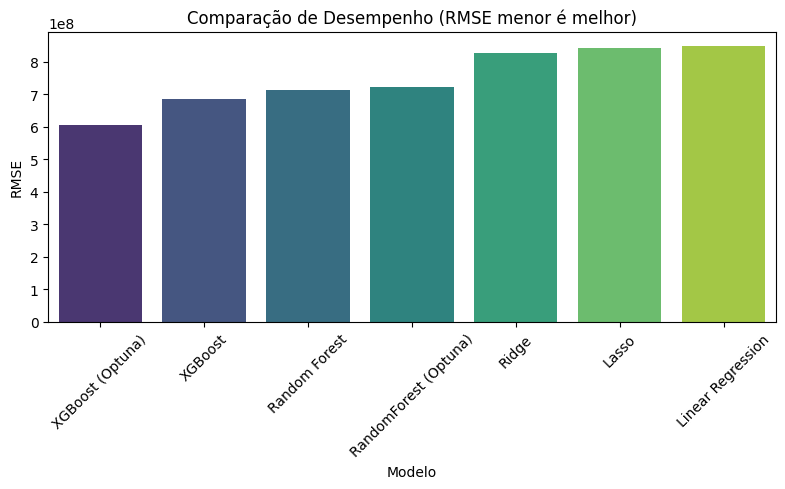

In [49]:
plt.figure(figsize=(8, 5))
sns.barplot(data=final_df, x='Modelo', y='RMSE', palette='viridis', hue='Modelo')
plt.xticks(rotation=45)
plt.title('Comparação de Desempenho (RMSE menor é melhor)')
plt.tight_layout()
plt.show()


Salvando artefatos

In [96]:
joblib.dump(best_rf, 'Resultados/best_random_forest_optuna.joblib')
joblib.dump(best_xgb, 'Resultados/best_xgboost_optuna.joblib')
final_df.to_csv('comparacao_modelos.csv', index=False)

print("\nModelos e resultados salvos com sucesso!")


Modelos e resultados salvos com sucesso!
